Original notebook here (https://github.com/urgedata/pythondata/blob/master/fbprophet/fbprophet_market_forecasts.ipynb)

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline
 
plt.rcParams['figure.figsize']=(10,10)
plt.style.use('ggplot')

In [2]:
# Read in hourly bitcoin price from conbase - price data provided via http://bitcoinity.org
df = pd.read_csv('http://data.bitcoinity.org/export_data.csv?currency=USD&data_type=price&exchange=coinbase&r=hour&t=l&timespan=30d', parse_dates=['Time'])

# Set the date/time to be the index for the dataframe
df.set_index('Time', inplace=True)
df.head()

avg       max       min
Time                                                 
2017-12-25 23:00:00  14163.885192  14200.00  14101.03
2017-12-26 00:00:00  14233.272726  14290.00  14171.98
2017-12-26 01:00:00  14206.052697  14248.00  14184.39
2017-12-26 02:00:00  14270.790795  14349.98  14190.03
2017-12-26 03:00:00  14594.689961  14999.00  14258.00

In [ ]:
# Plot the hourly prices

ax = df['avg'].plot(title="Bitcoin daily price USD")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

In [ ]:
# For forecasting, Prophet requires a dataframe with two columns:
# 'ds' for the date/time
# 'y' for the value to forecast

df['ds'] = df.index
df['y'] = df['avg']

forecast_data = df[['ds', 'y']].copy()
forecast_data.reset_index(inplace=True)
del forecast_data['Time']
forecast_data.head()

In [ ]:
# Create the Prophet model and fit the data

m = Prophet()
m.fit(forecast_data);

future = m.make_future_dataframe(periods=96, freq='H')
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# Plot the forecast
fig = m.plot(forecast, xlabel='Date', ylabel='Price (USD)');
plt.title('Bitcoin price forecast (USD)')
fig.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

In [ ]:
# What's the forecast for the next hour?

start_date =  datetime.datetime.now()
end_date = start_date + datetime.timedelta(hours=1)

forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)].head()[['ds','yhat']]

In [ ]:
# Let's look at the model components to see what trends and seasonality has been detected
# It looks like the cheapest time to buy bitcoin is 06:00am on a Friday

m.plot_components(forecast)

# Part #2 -> Applying Prophet to crypto data

In [19]:
import time
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [20]:
def hourly_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

Max length = 2001
Max time = 83 days 08:00:00


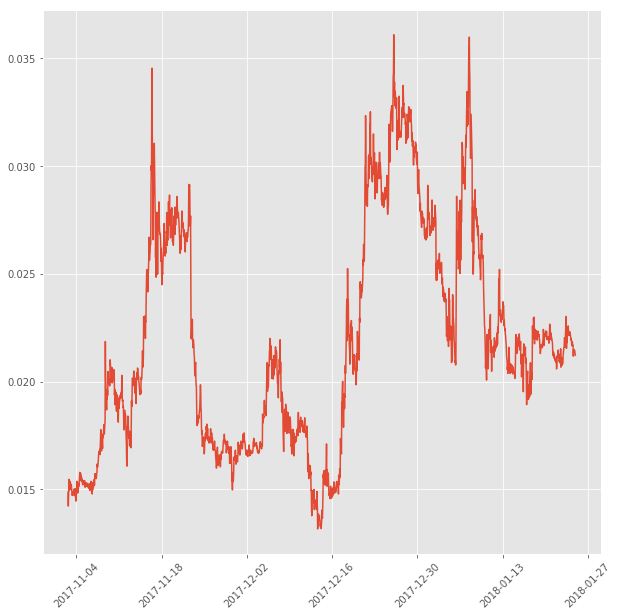

In [21]:
time_delta = 1 # Bar width in hours
df = hourly_price_historical('LSK', 'ETH', 9999, time_delta)
print('Max length = %s' % len(df))
print('Max time = %s' % (df.timestamp.max() - df.timestamp.min()))

plt.plot(df.timestamp, df.close)
plt.xticks(rotation=45)
plt.show()

In [22]:
df.tail()

close     high      low     open        time  volumefrom  volumeto  \
1996  0.02148  0.09306  0.09194  0.09236  1516816800    22375.80    480.64   
1997  0.02142  0.09303  0.09224  0.09280  1516820400    19111.15    409.41   
1998  0.02141  0.09296  0.09212  0.09250  1516824000    33018.21    706.79   
1999  0.02128  0.09329  0.09231  0.09320  1516827600    36722.46    781.33   
2000  0.02122  0.09309  0.02122  0.09290  1516831200    18668.82    396.27   

               timestamp  
1996 2018-01-24 19:00:00  
1997 2018-01-24 20:00:00  
1998 2018-01-24 21:00:00  
1999 2018-01-24 22:00:00  
2000 2018-01-24 23:00:00

In [23]:
df['ds'] = df['timestamp']
df['y'] = df['close']

forecast_data = df[['ds', 'y']].copy()
forecast_data.head()

ds        y
0 2017-11-02 15:00:00  0.01487
1 2017-11-02 16:00:00  0.01423
2 2017-11-02 17:00:00  0.01478
3 2017-11-02 18:00:00  0.01517
4 2017-11-02 19:00:00  0.01547

In [24]:
# Create the Prophet model and fit the data

m = Prophet()
m.fit(forecast_data);

future = m.make_future_dataframe(periods=24, freq='H')
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/gabrielfior/miniconda3/envs/tensorflow/lib/python3.4/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


ds      yhat  yhat_lower  yhat_upper
2015 2018-01-25 14:00:00  0.020272    0.017739    0.022858
2016 2018-01-25 15:00:00  0.020206    0.017764    0.022658
2017 2018-01-25 16:00:00  0.020177    0.017766    0.022788
2018 2018-01-25 17:00:00  0.020176    0.017697    0.022568
2019 2018-01-25 18:00:00  0.020172    0.017691    0.022547
2020 2018-01-25 19:00:00  0.020136    0.017503    0.022665
2021 2018-01-25 20:00:00  0.020064    0.017699    0.022718
2022 2018-01-25 21:00:00  0.019978    0.017448    0.022483
2023 2018-01-25 22:00:00  0.019903    0.017474    0.022404
2024 2018-01-25 23:00:00  0.019853    0.017317    0.022290

Text(0.5,1,'ETH price forecast (USD)')

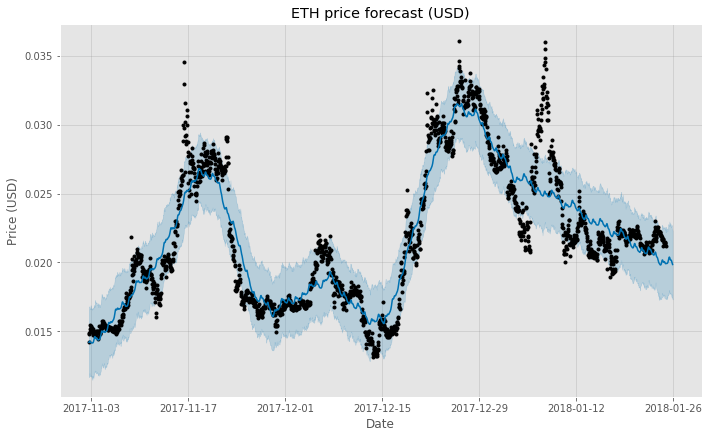

In [25]:
# Plot the forecast
fig = m.plot(forecast, xlabel='Date', ylabel='Price (USD)');
plt.title('ETH price forecast (USD)')
#fig.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.000f}'))

In [13]:
# What's the forecast for the next day?

start_date =  datetime.datetime.now()
end_date = start_date + datetime.timedelta(days=1)

forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)].head()[['ds','yhat']]

ds      yhat
2001 2018-01-25 00:00:00  0.000468
2002 2018-01-25 01:00:00  0.000468
2003 2018-01-25 02:00:00  0.000469
2004 2018-01-25 03:00:00  0.000469
2005 2018-01-25 04:00:00  0.000468

In [ ]:
forecast.tail()

In [ ]:
def coin_list():
    url = 'https://www.cryptocompare.com/api/data/coinlist/'
    page = requests.get(url)
    data = page.json()['Data']
    return data

In [ ]:
list_coins = coin_list()

In [ ]:
coins = pd.DataFrame.from_dict(list_coins, orient='index')
#CoinName, Symbol

In [ ]:
coins = coins.reset_index(drop=True)

In [ ]:
coins[coins.Symbol=='IOT']

In [ ]:
# Plotting IOTA
time_delta = 1 # Bar width in hours
df = hourly_price_historical('IOT', 'USD', 9999, time_delta)
print('Max length = %s' % len(df))
print('Max time = %s' % (df.timestamp.max() - df.timestamp.min()))

plt.plot(df.timestamp, df.close)
plt.xticks(rotation=45)
plt.show()

In [ ]:
coins[coins.CoinName=='Stellar']

In [ ]:
def plot_next_day(coinSymbol):
    print('Fetching data for {}'.format(coinSymbol))
    time_delta = 1 # Bar width in hours
    
    # testing connection
    r = requests.get('https://httpbin.org/get')
    if r.status_code != requests.status_codes.codes.OK:
        raise new Exception('Cannot fetch data from internet. Status code was {}'.format(r.status_code))
    
    df = hourly_price_historical(coinSymbol, 'USD', 9999, time_delta)
    print('Max length = %s' % len(df))
    print('Max time = %s' % (df.timestamp.max() - df.timestamp.min()))

    plt.plot(df.timestamp, df.close)
    plt.xticks(rotation=45)
    plt.show()
    
    # Processing for prophet
    df['ds'] = df['timestamp']
    df['y'] = df['close']
    forecast_data = stellar[['ds', 'y']].copy()
    forecast_data.head()
    
    # Create the Prophet model and fit the data

    m = Prophet()
    m.fit(forecast_data);

    # predict 1 week
    future = m.make_future_dataframe(periods=168, freq='H')
    future.tail()

    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

    # Plot the forecast
    print(forecast.ds.max())
    fig = m.plot(forecast, xlabel='Date', ylabel='Price (USD)');
    plt.title('{} price forecast (USD)'.format(coinSymbol))
    fig.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
    
    print(type(forecast))
    return forecast    

In [ ]:
# Plotting Stellar
time_delta = 1 # Bar width in hours
stellar = hourly_price_historical('XLM', 'USD', 9999, time_delta)
print('Max length = %s' % len(df))
print('Max time = %s' % (stellar.timestamp.max() - stellar.timestamp.min()))

plt.plot(stellar.timestamp, stellar.close)
plt.xticks(rotation=45)
plt.show()

In [ ]:
stellar['ds'] = stellar['timestamp']
stellar['y'] = stellar['close']

forecast_data = stellar[['ds', 'y']].copy()
forecast_data.head()

In [ ]:
# Create the Prophet model and fit the data

m = Prophet()
m.fit(forecast_data);

future = m.make_future_dataframe(periods=96, freq='H')
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# Plot the forecast
print(forecast.ds.max())
fig = m.plot(forecast, xlabel='Date', ylabel='Price (USD)');
plt.title('ETH price forecast (USD)')
fig.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

In [ ]:
# What's the forecast for the next day?

start_date =  datetime.datetime.now()
end_date = start_date + datetime.timedelta(days=1)

forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)].head()[['ds','yhat']]

In [ ]:
forecast_eth = plot_next_day(coinSymbol='ETH')

In [ ]:
# calculate return after today
#forecast[forecast.ds== datetime.datetime(day=23, month=1, year=2018)]
forecast_eth.head()

In [ ]:
df[df.timestamp== datetime.datetime(day=22, month=1, year=2018)]